In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import missingno as msno
import pdb

In [2]:
king_county = pd.read_csv('./data/EXTR_RPSale.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_KC = pd.DataFrame(king_county)

In [4]:
sales_price_dict = dict(df_KC.SalePrice.value_counts())
total = 0
for key, val in sales_price_dict.items():
    if key != 0:
        total += val
print("Total number of Sales Price > $0 = {}".format(total))
print("Total number of Sales Price = $0 = {}".format(sales_price_dict[0]))
print("Percentage of missing values = {}".format(sales_price_dict[0]/total))

Total number of Sales Price > $0 = 1337800
Total number of Sales Price = $0 = 706282
Percentage of missing values = 0.5279428913140978


In [5]:
# stripping all cells with leading or trailing spaces
df_KC = df_KC.applymap(lambda x: x.strip() if type(x) == str else x)

In [6]:
# replacing empty strings with nan values 
df_KC = df_KC.replace(to_replace='', value=np.nan)

We can go ahead and drop all rows from a column with < 550 NA's because we have ~1.9 mil values.

In [8]:
# dropping all rows with na values in any of the columns listed below.
df_KC = df_KC.dropna(axis=0,subset=['RecordingNbr', 'Major','Minor','SellerName','BuyerName'])

After analysis of the data, we concluded that we should not replace the NA's of columns that have 70% of it's data missing. We are going to drop those columns.

In [31]:
# drops the columns from the list below
drop_columns = ['Volume','Page','PlatNbr','PlatType','PlatLot','PlatBlock','SaleWarning','AFForestLand','AFCurrentUseLand','AFNonProfitUse', 'AFHistoricProperty']
df_KC = df_KC.drop(axis=1,columns=drop_columns)

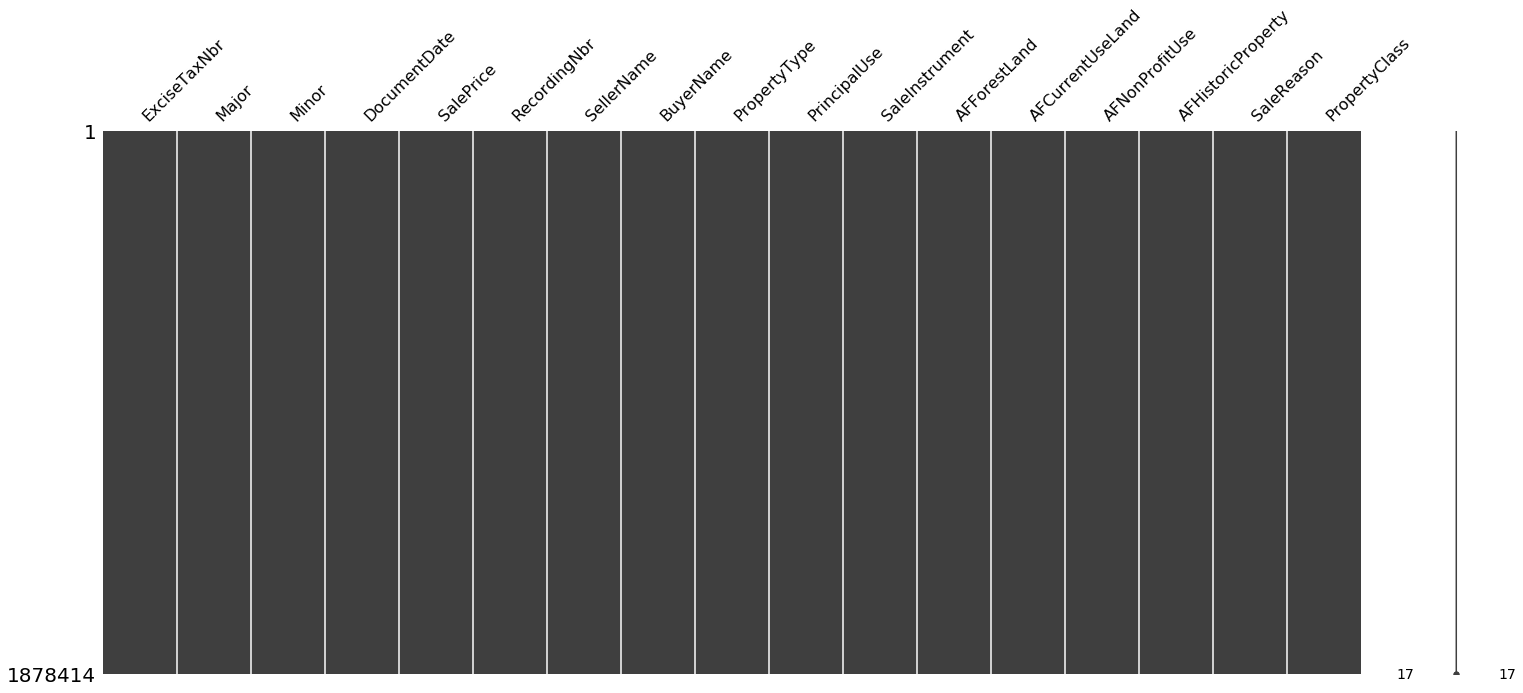

In [10]:
msno.matrix(df_KC)

In [11]:
df_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878414 entries, 0 to 2044081
Data columns (total 17 columns):
ExciseTaxNbr          int64
Major                 object
Minor                 object
DocumentDate          object
SalePrice             int64
RecordingNbr          object
SellerName            object
BuyerName             object
PropertyType          int64
PrincipalUse          int64
SaleInstrument        int64
AFForestLand          object
AFCurrentUseLand      object
AFNonProfitUse        object
AFHistoricProperty    object
SaleReason            int64
PropertyClass         int64
dtypes: int64(7), object(10)
memory usage: 258.0+ MB


In [12]:
# Creating lists of columns with similar types.
kc_int_columns = ['ExciseTaxNbr', 'Major', 'Minor', 'SalePrice', 'RecordingNbr', 'PropertyType', 'PrincipalUse', 'SaleInstrument', 'SaleReason', 'PropertyClass']
kc_str_columns = ['SellerName', 'BuyerName', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse', 'AFHistoricProperty']

In [13]:
for column in kc_int_columns:
    df_KC[column] = df_KC[column].apply(int)

In [14]:
# convert appropriate columns to str
for column in kc_str_columns:
    df_KC[column] = df_KC[column].apply(str)

In [15]:
# convert DocumentDate column to datetime
df_KC['DocumentDate'] = pd.to_datetime(df_KC['DocumentDate'],errors='coerce')

In [16]:
df_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878414 entries, 0 to 2044081
Data columns (total 17 columns):
ExciseTaxNbr          int64
Major                 int64
Minor                 int64
DocumentDate          datetime64[ns]
SalePrice             int64
RecordingNbr          int64
SellerName            object
BuyerName             object
PropertyType          int64
PrincipalUse          int64
SaleInstrument        int64
AFForestLand          object
AFCurrentUseLand      object
AFNonProfitUse        object
AFHistoricProperty    object
SaleReason            int64
PropertyClass         int64
dtypes: datetime64[ns](1), int64(10), object(6)
memory usage: 258.0+ MB


In [17]:
df_KC.isnull().sum()

ExciseTaxNbr          0
Major                 0
Minor                 0
DocumentDate          0
SalePrice             0
RecordingNbr          0
SellerName            0
BuyerName             0
PropertyType          0
PrincipalUse          0
SaleInstrument        0
AFForestLand          0
AFCurrentUseLand      0
AFNonProfitUse        0
AFHistoricProperty    0
SaleReason            0
PropertyClass         0
dtype: int64

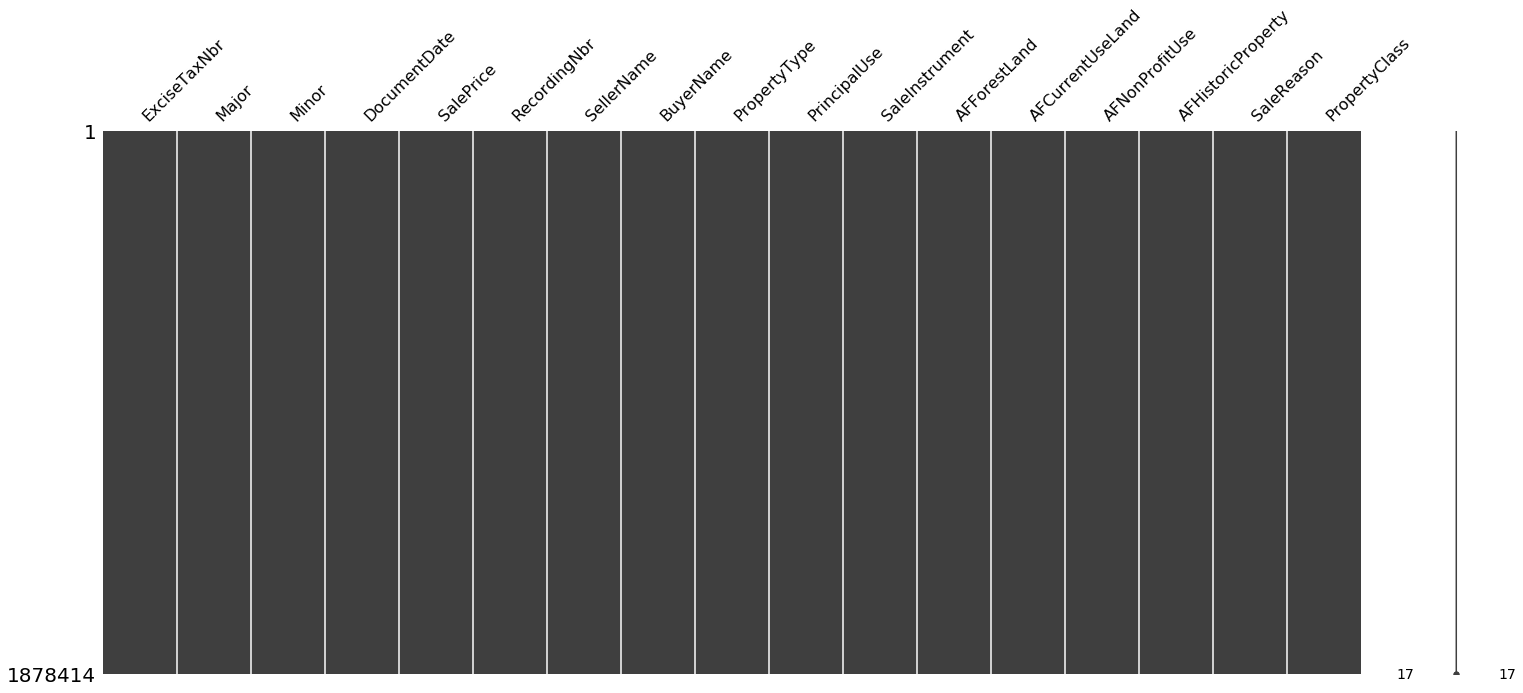

In [18]:
msno.matrix(df_KC)

In [19]:
for column in df_KC:
    print(df_KC[column].value_counts())

2639648    689
2673898    685
2003168    267
1610536    244
2582042    228
          ... 
2920664      1
2922713      1
2916570      1
2918619      1
889266       1
Name: ExciseTaxNbr, Length: 1715451, dtype: int64
375160    4566
343850    3967
510140    3902
276760    3899
277060    3640
          ... 
322611       1
42612        1
517570       1
312504       1
322309       1
Name: Major, Length: 16725, dtype: int64
20      35207
10      35170
30      33951
40      33100
50      31540
        ...  
4339        1
7841        1
5363        1
8921        1
6736        1
Name: Minor, Length: 7541, dtype: int64
2014-06-11    911
2013-11-05    846
2004-10-07    764
2005-12-01    763
2006-12-05    737
             ... 
1991-01-13      1
1976-03-10      1
1981-10-09      1
1977-10-17      1
1970-01-01      1
Name: DocumentDate, Length: 13082, dtype: int64
0         667133
250000      6617
300000      6315
200000      5987
350000      5885
           ...  
425659         1
417471         1
376

In [40]:
drop_0_columns = ['PropertyClass', 'SaleReason', 'PrincipalUse','SaleInstrument','PropertyType']

property_class_replacements = {1:'C/I-Land only',
                               2:'C/I-Imp prop; no condo/MH',
                               3:'C/I-Condominium',
                               4:'C/I-Air rights only',
                               5:'C/I-Imp prop excl air rights',
                               6:'C/I-Land or bldg; no split',
                               7:'Res-Land only',
                               8:'Res-Improved property',
                               9:'Res or C/I-Mobile Home'}
sale_reason_replacements = {
    1:'None',
    10:'Property Settlement',
    11:'Divorce Settlement',
    12:'Tenancy Partition',
    13:'Community Prop Established',
    14:'Partial Int - love,aff,gft',
    15:'Easement',
    16:'Correction (refiling)',
    17:'Trade',
    18:'Other',
    19:'Quit Claim Deed - gift/full or part interest',
    2:'Assumption',
    3:'Mortgage Assumption',
    4:'Foreclosure',
    5:'Trust',
    6:'Executor-to admin guardian',
    7:'Testamentary Trust',
    8:'Estate Settlement',
    9:'Settlement'
}
principal_use_replacements = {
     1:'AGRICULTURAL',
     10:'OTHER',
     11:'COMMERCIAL/INDUSTRIAL',
     2:'CONDOMINIUM',
     3:'RECREATIONAL',
     4:'APT(4+ UNITS)',
     5:'INDUSTRIAL',
     6:'RESIDENTIAL',
     7:'COMMERCIAL',
     8:'MOBILE HOME',
     9:'TIMBER'
           }

sale_instrument_replacements = {
    1:"None",                                              
    10:"Real Estate Contract",                              
    11:"Purchaser's Assignment",                            
    13:"Seller's Assignment",                               
    15:"Quit Claim Deed",                                   
    18:"Trustees' Deed",                                    
    19:"Executor's Deed",                                   
    2:"Warranty Deed",                                     
    20:"Fiduciary Deed",                                    
    21:"Sheriff's Deed",                                    
    22:"Bargain and Sales Deed",                            
    23:"Receivers Deed",                                    
    24:"Deed of Personal Rep",                              
    25:"Judgment Per Stipulation",                          
    26:"Other - See Affidavit",                             
    27:"DEED",                                              
    28:"Forfeiture Real Estate Contract",                   
    3:"Statutory Warranty Deed",                           
    4:"Special Warranty Deed",                             
    5:"Corporate Warranty Deed",                           
    6:"Assumption Warranty Deed",                          
    7:"Grant Deed",                                        
    8:"Contract (equity)",                                 
    9:"Contract (installment)",                            
}

property_type_replacements = {
    1:'LAND ONLY',                                          
    10:'Land with new building',                             
    11:'Household, single family units',                     
    12:'Multiple family residence (Residential, 2-4 units)',
    13:'Multiple family residence (Residential, 5+ units)',
    14:'Residential condominiums',                           
    15:'Mobile home parks or courts',                        
    16:'Hotels/motels',                                      
    17:'Institutional lodging',                              
    18:'All other residential not elsewhere coded',          
    19:'Vacation and cabin',                                 
    2:'LAND WITH NEW BUILDING',                             
    21:'Food and kindred products',                          
    22:'Textile mill products',                              
    23:'Apparel & other finished products',                  
    24:'Lumber and wood products (except furniture)',        
    25:'Furniture and fixtures',                             
    26:'Paper and allied products',                          
    27:'Printing and publishing',                            
    28:'Chemicals',                                          
    29:'Petroleum refining and related industries',          
    3:'LAND WITH PREV USED BLDG',                           
    30:'Rubber and miscellaneous plastic products',          
    31:'Leather and leather products',                       
    32:'Stone, clay and glass products',                     
    33:'Primary metal industries',                           
    34:'Fabricated metal products',                          
    35:'Prof. scientific, controlling instr; optical goods',
    39:'Miscellaneous manufacturing',                        
    4:'LAND WITH MOBILE HOME',                              
    41:'Railroad/transit transportation',                    
    42:'Motor vehicle transportation',                       
    43:'Aircraft transportation',                            
    44:'Marine craft transportation',                        
    45:'Highway and street right of way',                    
    46:'Automobile parking',                                 
    47:'Communication',                                      
    48:'Utilities',                                          
    49:'Other transp., com., & util. not classified',        
    5:'TIMBER ONLY',                                        
    50:'Condominiums - other than residential condominiums', 
    51:'Wholesale trade',                                    
    52:'Retail trade-bldg materials, hardware, farm equip',  
    53:'Retail trade - general merchandise',                 
    54:'Retail trade - food',                                
    55:'Retail trade-autom., marine craft, aircraft',        
    56:'Retail trade - apparel and accessories',             
    57:'Retail trade-furniture, home furnishings, equip.',   
    58:'Retail trade-eating & drinking',                     
    59:'Tenant occupied, commercial properties',             
    6:'BUILDING ONLY',                                      
    61:'Finance, insurance, and real estate services',       
    62:'Personal services',                                  
    63:'Business services',                                  
    64:'Repair services',                                    
    65:'Professional services (medical, dental, etc.)',      
    66:'Contract construction services',                     
    67:'Governmental services',                              
    68:'Educational services',                               
    69:'Miscellaneous services',                             
    71:'Cultural activities and nature exhibitions',         
    72:'Public assembly',                                    
    73:'Amusements',                                         
    74:'Recreational activities (gold courses, etc.)',       
    75:'Resorts and group camps',                            
    76:'Parks',                                              
    79:'Other cultural, entertainment, and recreational',    
    80:'Water or Mineral rights',                            
    81:'Agriculture (not classified under current use law)',
    82:'Agriculture related activities',                     
    83:'Agr classified under current use chapter 84.34 RCW', 
    84:'Fishing activities and related services',            
    85:'Mining activities and related services',             
    86:'Standing Timber (separate from land)',               
    88:'Forest land designated under chapter 84.33 RCW', 
    89:'Other resource production',                          
    9:'Land with mobile home',                              
    91:'Undeveloped land (land only)',                       
    92:'Noncommercial forest',                               
    93:'Water areas',                                        
    94:'Open space land classified under chapter 84.34 RCW', 
    95:'Timberland classified under chapter 84.34 RCW', 
    96:'Improvements on leased land',                        
    99:'Other undeveloped land',                             
}

In [29]:
df_KC['PropertyClass'].replace(property_class_replacements, inplace=True)
df_KC['SaleReason'].replace(sale_reason_replacements, inplace=True)
df_KC['PropertyType'].replace(property_type_replacements, inplace=True)
df_KC['PrincipalUse'].replace(principal_use_replacements, inplace=True)
df_KC['SaleInstrument'].replace(sale_instrument_replacements, inplace=True)

df_KC.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass
0,2324275,142205,9172,2007-12-05,650000,20071212001568,COLE VERN+JITKA,MINTON DAVID W+KIMBERLY A,LAND WITH PREV USED BLDG,RESIDENTIAL,Statutory Warranty Deed,N,N,N,N,None,Res-Improved property
1,952729,278470,10,1987-07-10,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,LAND WITH PREV USED BLDG,0,Quit Claim Deed,N,N,N,N,Other,C/I-Condominium
2,952729,278470,40,1987-07-10,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,LAND WITH PREV USED BLDG,0,Quit Claim Deed,N,N,N,N,Other,C/I-Condominium
3,952729,278470,100,1987-07-10,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,LAND WITH PREV USED BLDG,0,Quit Claim Deed,N,N,N,N,Other,C/I-Condominium
4,952729,278470,190,1987-07-10,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,LAND WITH PREV USED BLDG,0,Quit Claim Deed,N,N,N,N,Other,C/I-Condominium


In [ ]:
for x in drop_0_columns:
    df_KC[x] = df_KC[x].replace(to_replace=0, value=np.nan)
    df_KC = df_KC.dropna(axis=0,subset=[x])

In [42]:
for column in df_KC:
    print(df_KC[column].value_counts())

2673898    685
2003168    267
1610536    244
2590623    228
2582042    228
          ... 
2273009      1
2275058      1
2277107      1
2262772      1
2099201      1
Name: ExciseTaxNbr, Length: 1435430, dtype: int64
375160    3646
276760    3368
343850    3246
510140    3147
277060    3074
          ... 
362308       1
122108       1
395300       1
222409       1
517570       1
Name: Major, Length: 16421, dtype: int64
10      29956
20      29947
30      28753
40      27962
50      26706
        ...  
6403        1
3857        1
5373        1
2832        1
6608        1
Name: Minor, Length: 7379, dtype: int64
2014-06-11    911
2005-12-01    763
2004-10-07    750
2006-12-05    736
2005-04-26    612
             ... 
1965-12-22      1
1990-12-01      1
1991-10-27      1
1968-08-29      1
1985-09-24      1
Name: DocumentDate, Length: 12164, dtype: int64
0          545066
250000       5818
300000       5674
350000       5410
200000       5034
            ...  
114242          1
2215500      

In [44]:
pickled_KC= pd.to_pickle(df_KC, './data/cleaned_KC.pkl')

In [46]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')

In [48]:
cleaned_KC.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,SaleReason,PropertyClass
0,2324275,142205,9172,2007-12-05,650000,20071212001568,COLE VERN+JITKA,MINTON DAVID W+KIMBERLY A,LAND WITH PREV USED BLDG,RESIDENTIAL,Statutory Warranty Deed,None,Res-Improved property
18,2163790,868228,510,2005-10-19,394995,20051021003534,SHEA HOMES INC,FOSSE ALLYN O+R MARIE,LAND WITH NEW BUILDING,RESIDENTIAL,Statutory Warranty Deed,None,Res-Improved property
19,1965001,137080,1005,2003-05-22,0,20030612001318,FREIDMAN MICHAEL R+SHIRLEY A,FREIDMAN MICHAEL R+SHIRLEY A,LAND WITH PREV USED BLDG,RESIDENTIAL,Quit Claim Deed,Trust,Res-Improved property
20,2739134,261000,150,2015-06-22,0,20150626000484,PHAN HOA THI+THIEN CHI TRAN,VO HAI MINH+LE NHAT TRAN,LAND WITH PREV USED BLDG,RESIDENTIAL,Quit Claim Deed,Other,Res-Improved property
21,1780282,928610,220,2000-10-03,292500,20001005001133,CAMWEST DEVELOMENT INC,RETACCO WENDY E,LAND WITH NEW BUILDING,RESIDENTIAL,Statutory Warranty Deed,None,Res-Improved property
